# Fingerprinting Movement Disorders in Fruit Flies - Baseline Script

**Author:** Shehel Yoosuf  
**Created:** February 04, 2025

This notebook contains baseline code for the Kaggle competition "Fingerprinting Movement Disorders in Fruit Flies". 
By the end of this notebook, we will have a submission file ready to be uploaded to the competition.

Prerequisites:
- Create a main directory and move this notebook into it.
- Download 
  - keypoints_train.zip - the training set consisting of .slp files containing keypoints
  - labels_train.csv - Ground truth labels with ID and TARGET for each .slp file in keypoints_train.zip
  - keypoints_test.zip - the test set consisting of .slp files containing keypoints
- Extract the .slp files in the keypoints_train.zip and keypoints_test.zip into the ./data/keypoints_train and ./data/keypoints_test directories respectively.
- Move the labels_train.csv file into the ./data directory.



In [ ]:
# Install dependencies
!pip install sleap
!pip install xgboost
!pip install scikit-learn
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install cattrs
!pip install opencv-python
!pip install python-rapidjson
!pip install jsmin
!pip install albumentations

# Uninstall standalone keras if you are using tensorflow's keras
!pip uninstall keras -y

# Install or upgrade tensorflow
!pip install tensorflow --upgrade



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Load Data

In [ ]:
# Load all TRAIN .slp files
import glob
import sleap

def load_slp_files(path):
    """
    Load all .slp files from the given path and return their points
    
    Args:
        path (str): Path to directory containing .slp files
        
    Returns:
        list: List of loaded SLEAP label files
    """
    slp_files = glob.glob(f'{path}/*.slp')
    slp_points = []
    for file in slp_files:
        keypoints = sleap.load_file(file)
        slp_points.append(keypoints)
    return slp_points

train_slp_points = load_slp_files('./keypoints_train')


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


ImportError: cannot import name 'tf_utils' from 'keras.utils' (C:\Users\jingj\AppData\Roaming\Python\Python312\site-packages\keras\api\utils\__init__.py)

In [2]:
len(train_slp_points)

NameError: name 'train_slp_points' is not defined

## Data Exploration


### Inspecting a .slp keypoints file

- Each .slp file contains a list of frames. Each frame contains a list of instances. In our case, we only have a single fly/instance per frame. 
- Each instance contains a list of x-y points corresponding to the fly's keypoints.
- Each point is also given a confidence score which gives an indication of the quality of the estimation. There's also an aggregated score for the entire instance.




In [15]:
train_slp_points[0].skeleton.nodes

[Node(name='forelegR1', weight=1.0),
 Node(name='forelegR2', weight=1.0),
 Node(name='forelegR3', weight=1.0),
 Node(name='forelegR4', weight=1.0),
 Node(name='midlegR1', weight=1.0),
 Node(name='midlegR2', weight=1.0),
 Node(name='midlegR3', weight=1.0),
 Node(name='midlegR4', weight=1.0),
 Node(name='hindlegR1', weight=1.0),
 Node(name='hindlegR2', weight=1.0),
 Node(name='hindlegR3', weight=1.0),
 Node(name='hindlegR4', weight=1.0),
 Node(name='forelegL1', weight=1.0),
 Node(name='forelegL2', weight=1.0),
 Node(name='forelegL3', weight=1.0),
 Node(name='forelegL4', weight=1.0),
 Node(name='midlegL1', weight=1.0),
 Node(name='midlegL2', weight=1.0),
 Node(name='midlegL3', weight=1.0),
 Node(name='midlegL4', weight=1.0),
 Node(name='hindlegL1', weight=1.0),
 Node(name='hindlegL2', weight=1.0),
 Node(name='hindlegL3', weight=1.0),
 Node(name='hindlegL4', weight=1.0),
 Node(name='neck1', weight=1.0),
 Node(name='thorax1', weight=1.0)]

In [16]:
train_slp_points[0][0].instances[0]

PredictedInstance(video=Video(filename=/home/shehel/Documents/sleap/processed/dataset/FLY_82.mp4, shape=(None, None, None, None), backend=MediaVideo), frame_idx=0, points=[forelegR1: (604.9, 310.3, 0.78), forelegR2: (633.9, 284.3, 0.58), forelegR3: (638.9, 281.3, 0.71), forelegR4: (666.9, 253.3, 0.77), midlegR1: (572.9, 324.3, 0.80), midlegR2: (549.9, 302.3, 0.84), midlegR3: (546.9, 298.3, 0.79), midlegR4: (513.9, 264.3, 0.92), hindlegR1: (560.9, 338.3, 0.80), hindlegR2: (507.9, 335.3, 0.60), hindlegR3: (475.9, 345.3, 0.71), hindlegR4: (413.9, 345.3, 0.89), forelegL1: (615.9, 347.3, 0.69), forelegL2: (632.9, 350.3, 0.37), forelegL3: (649.9, 324.3, 0.22), midlegL1: (598.9, 361.3, 0.78), midlegL2: (611.9, 391.3, 0.62), midlegL3: (625.9, 396.3, 0.70), midlegL4: (655.9, 426.3, 0.81), hindlegL1: (575.9, 367.3, 0.85), hindlegL2: (566.9, 406.3, 0.83), hindlegL3: (555.9, 412.3, 0.87), hindlegL4: (539.9, 464.3, 0.98), neck1: (622.9, 319.3, 0.83), thorax1: (576.9, 347.3, 0.87)], score=0.80, trac

In [17]:
train_slp_points[0][0].instances[0].points

(PredictedPoint(x=604.864501953125, y=310.33489990234375, visible=True, complete=False, score=0.779952347278595),
 PredictedPoint(x=633.8534545898438, y=284.31842041015625, visible=True, complete=False, score=0.5776529908180237),
 PredictedPoint(x=638.8521118164062, y=281.3275451660156, visible=True, complete=False, score=0.7103322148323059),
 PredictedPoint(x=666.8635864257812, y=253.32479858398438, visible=True, complete=False, score=0.766862154006958),
 PredictedPoint(x=572.867431640625, y=324.3210754394531, visible=True, complete=False, score=0.7972205281257629),
 PredictedPoint(x=549.8673095703125, y=302.3197937011719, visible=True, complete=False, score=0.8355197906494141),
 PredictedPoint(x=546.85400390625, y=298.32904052734375, visible=True, complete=False, score=0.7898843884468079),
 PredictedPoint(x=513.8516845703125, y=264.3203125, visible=True, complete=False, score=0.918610692024231),
 PredictedPoint(x=560.86474609375, y=338.3266296386719, visible=True, complete=False, sco

NameError: name 'train_slp_points' is not defined

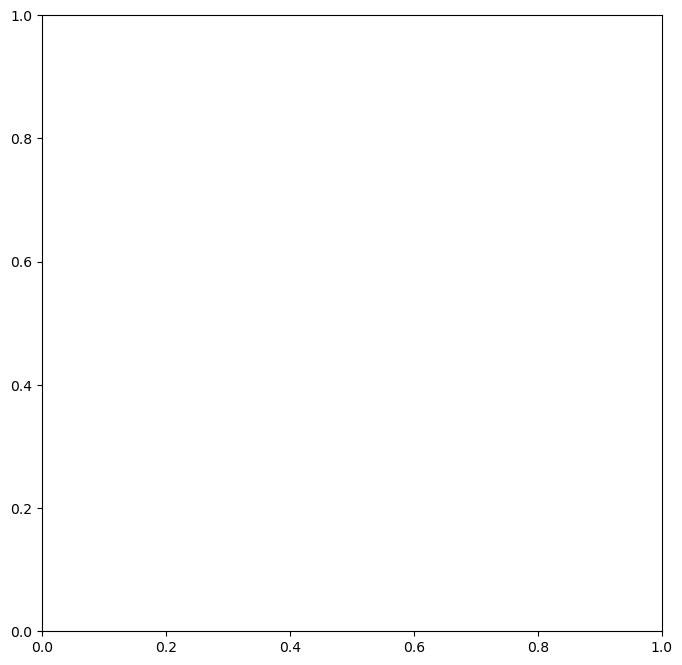

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_points(labeled_frame, scale=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    ax.clear()
    ax.set_xlim(0, 720)
    ax.set_ylim(720, 0)  # Flipped y-axis
    
    cmap = sns.color_palette("tab20")
    points = labeled_frame[0].numpy()
    for i, (x, y) in enumerate(points):
        x *= scale
        y *= scale
        ax.plot(x, y, '.', ms=10, c=cmap[i % len(cmap)])
        ax.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')

    ax.set_aspect('equal')
    ax.grid(True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Animation update function
def update(frame):
    plot_points(train_slp_points[0][frame], scale=1.0, ax=ax)
    ax.set_title(f'Frame {frame}')

# Create animation with all frames at 30 fps
total_frames = len(train_slp_points[0])
print("Total_frames: ", total_frames)
anim = FuncAnimation(fig, update, frames=200, interval=300)  # 1000ms/30 for 30fps
HTML(anim.to_jshtml())

- We observe that the fly is constantly changing its orientation. Therefore, we will need to rotate the fly body points to a standard orientation so that many features such as angles are easier to interpret.
- There could be estimation errors which we can try to check by plotting the part affinity fields (PAFs) score of each frame. 
- Implementing some filtering based on the scores will help us extract higher quality subsequences which can be used for training instead of the entire noisy sequences.
- Optionally, a more advanced approach would be to use per-keypoint confidence scores. These pre-processing steps may significantly improve results since the classification is at the video level. Therefore, it doesn't matter if we use all the frames or not. Throwing away noisy frames will help us get a better estimate of useful features.
- For now, we will use the PAF scores.


In [4]:
frame_idx = 0
print ("Frame {}:".format(frame_idx))
print ("PAF Score: ", train_slp_points[0][frame_idx].instances[0].score)
print ("Keypoint Confidence Scores: ", train_slp_points[0][frame_idx].instances[0].scores)

Frame 0:


NameError: name 'train_slp_points' is not defined

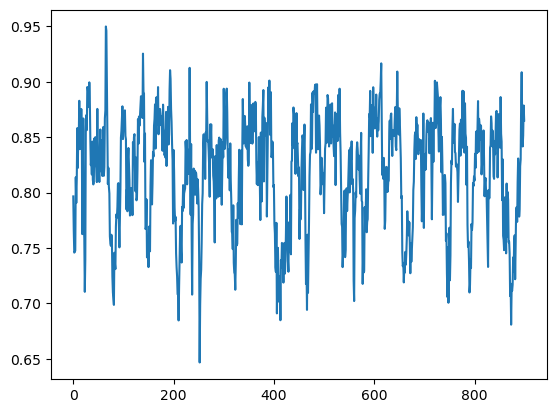

In [54]:
scores = [train_slp_points[0][i].instances[0].score for i in range(total_frames)]
plt.plot(scores, label='PAF Scores')

A simple pre-processing step could be use only sub-sequences of length with atleast 20 frames with a PAF score of atleast 0.8.

## Dataset Creation

- Rotate the fly body points to a standard orientation.
- From each video, we will extract subsequences of length 20 with a PAF score of atleast 0.8 and use the standard deviation of the euclidean norm of the limbs as features. This approach of taking 20 frames is fine since the fly completes several strides in 20 frames and it also increases the training set size.
- Create train and validation sets with 80-20 split.

In [5]:
import numpy as np

In [6]:
def get_rotated_fly_points(predictions, frame_range=None, plot=False, plot_size=(8, 8), limits=(-200, 200)):
    """
    Get thorax-centered and rotation-normalized fly body points, with optional visualization.
    
    Parameters:
    -----------
    predictions : numpy.ndarray
        Array of shape [frame, 1, 26, 2] containing tracking data
    frame_range : int or None
        Number of frames to process. If None, process all frames
    plot : bool
        Whether to create visualization plot
    plot_size : tuple
        Size of the plot in inches (width, height)
    limits : tuple
        Plot limits for both x and y axes (min, max)
        
    Returns:
    --------
    numpy.ndarray
        Array of rotated points with shape [num_frames, 26, 2]
    """
    
    def rotate_point(point, angle):
        """Rotate a point by given angle."""
        x, y = point
        new_x = x * np.cos(angle) - y * np.sin(angle)
        new_y = x * np.sin(angle) + y * np.cos(angle)
        return new_x, new_y

    # Process frames
    num_frames = len(predictions) if frame_range is None else min(len(predictions), frame_range)
    final_points_all = np.zeros((num_frames, 26, 2))
    
    for frame_idx in range(num_frames):
        points = predictions[frame_idx, 0]  # Shape: [26, 2]
        
        # Center and rotate points
        thorax = points[-1]
        centered_points = points - thorax
        neck_centered = centered_points[-2]
        angle = np.arctan2(neck_centered[1], neck_centered[0])
        
        # Rotate all points
        rotated_points = np.zeros_like(centered_points)
        for i in range(len(centered_points)):
            rotated_points[i] = rotate_point(centered_points[i], -angle)
        
        # Rotate whole frame by 90 degrees
        for i in range(len(rotated_points)):
            final_points_all[frame_idx, i] = rotate_point(rotated_points[i], np.pi/2)
    
    if plot:
        import matplotlib.pyplot as plt
        
        # Define color scheme
        colors = {
            'Thorax': 'purple',
            'Neck': 'red',
            'Foreleg Right': ['#FF0000', '#FF4000', '#FF8000', '#FFBF00'],
            'Foreleg Left': ['#0000FF', '#0040FF', '#0080FF', '#00BFFF'],
            'Hindleg Right': ['#004D00', '#006600', '#008000', '#009900'],
            'Hindleg Left': ['#4B0082', '#663399', '#8B008B', '#9932CC'],
            'Midleg Right': ['#8B4513', '#CD853F', '#DEB887', '#F4A460'],
            'Midleg Left': ['#1A1A1A', '#333333', '#4D4D4D', '#666666']
        }
        
        plt.figure(figsize=plot_size)
        
        # Plot points
        for frame_idx in range(num_frames):
            final_points = final_points_all[frame_idx]
            
            # Plot thorax and neck
            plt.scatter(final_points[-1, 0], final_points[-1, 1], 
                       color=colors['Thorax'], label='Thorax' if frame_idx == 0 else "", alpha=0.5)
            plt.scatter(final_points[-2, 0], final_points[-2, 1], 
                       color=colors['Neck'], label='Neck' if frame_idx == 0 else "", alpha=0.5)
            
            # Plot legs
            leg_types = ['Foreleg Right', 'Midleg Right', 'Hindleg Right', 
                        'Foreleg Left', 'Midleg Left', 'Hindleg Left']
            
            for leg_idx, leg_type in enumerate(leg_types):
                start_idx = leg_idx * 4 if leg_idx < 3 else (leg_idx - 3) * 4 + 12
                for i in range(4):
                    point_idx = start_idx + i
                    color = colors[leg_type][i]
                    label = f"{leg_type} {i+1}" if frame_idx == 0 else ""
                    plt.scatter(final_points[point_idx, 0], final_points[point_idx, 1],
                              color=color, label=label, alpha=0.5)
        
        plt.xlim(limits)
        plt.ylim(limits)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Scatter Plot of Rotated Points')
        plt.grid(True)
        plt.show()
    
    return final_points_all

In [20]:
# Below, we use a hack to avoid using the numpy() method directly on train_slp_points[x]
# We are doing this way to avoid using the numpy() method which causes compatibility issues with other functions
slp_numpy = [frame.numpy() for frame in train_slp_points[5]]
slp_numpy = np.concatenate(slp_numpy, axis=0)[:, np.newaxis, :, :]

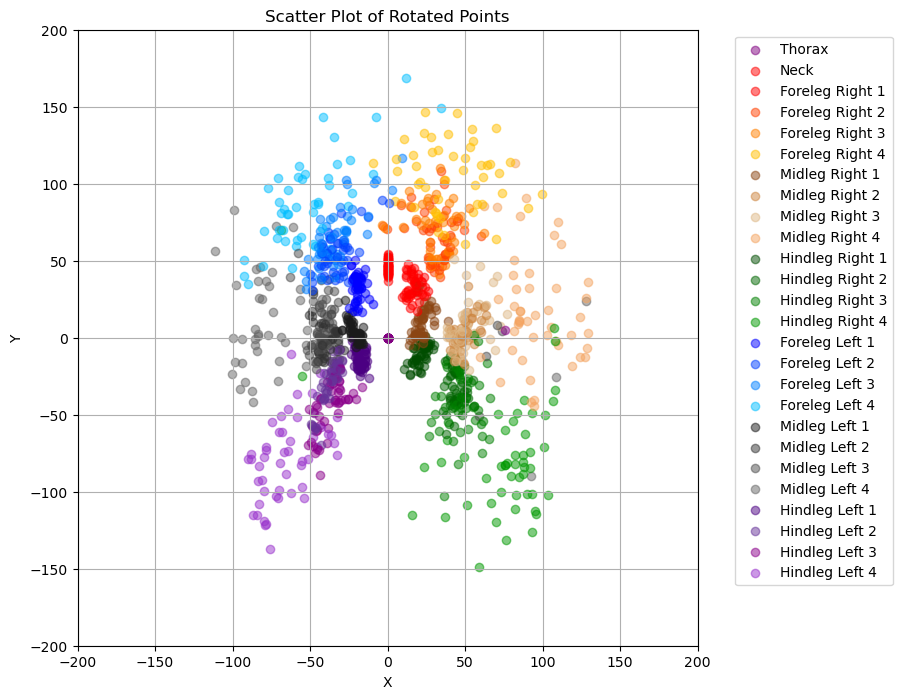

In [21]:
_ = get_rotated_fly_points(slp_numpy, frame_range=50, plot=True)

Perhaps the amount of variations in the limbs is a good feature for classification? 
Lets build a classifier to predict the target based on the limb variations, specifically the standard deviation of the euclidean norm of the limbs.

In [86]:
train_slp_points[0][0].numpy()

array([[[604.86450195, 310.3348999 ],
        [633.85345459, 284.31842041],
        [638.85211182, 281.32754517],
        [666.86358643, 253.32479858],
        [572.86743164, 324.32107544],
        [549.86730957, 302.3197937 ],
        [546.85400391, 298.32904053],
        [513.85168457, 264.3203125 ],
        [560.86474609, 338.32662964],
        [507.86364746, 335.33453369],
        [475.86279297, 345.3302002 ],
        [413.85681152, 345.3230896 ],
        [615.8560791 , 347.31872559],
        [632.86047363, 350.32247925],
        [649.85339355, 324.31884766],
        [         nan,          nan],
        [598.86047363, 361.31768799],
        [611.86767578, 391.33081055],
        [625.85571289, 396.32489014],
        [655.85955811, 426.32818604],
        [575.86364746, 367.31585693],
        [566.86193848, 406.31939697],
        [555.86132812, 412.32202148],
        [539.85272217, 464.32943726],
        [622.86584473, 319.32440186],
        [576.85919189, 347.32354736]]])

In [22]:
def process_slp_points(predictions, samples_per_inst=20, min_paf_score=0.75, use_all_frames=False):
    """Process a single video and return its std_devs features.
    
    Args:
        predictions: SLEAP predictor model
        samples_per_inst: Length of sub-sequences to extract (default: 20)
        min_paf_score: Minimum PAF score threshold for sub-sequences (default: 0.75)
        use_all_frames: If True, return single std_dev for entire video ignoring other params
    
    Returns:
        List of std_devs features, either for qualifying sub-sequences or whole video
    """
    slp_numpy = [frame.numpy() for frame in train_slp_points[0]]
    slp_numpy = np.concatenate(slp_numpy, axis=0)[:, np.newaxis, :, :]
    rotated_points = get_rotated_fly_points(slp_numpy, frame_range=None, plot=False)
    
    # Calculate euclidean norms
    euclidean_norms = np.linalg.norm(rotated_points, axis=2)
    
    # Get PAF scores for all frames
    paf_scores = np.array([frame.instances[0].score if len(frame.instances) > 0 else 0 for frame in predictions])
    
    # Handle NaN values, make it mean of t
    for i in range(euclidean_norms.shape[0]):
        for j in range(euclidean_norms.shape[1]):
            if np.isnan(euclidean_norms[i, j]):
                next_idx = i + 1
                while next_idx < euclidean_norms.shape[0] and np.isnan(euclidean_norms[next_idx, j]):
                    next_idx += 1
                
                if next_idx < euclidean_norms.shape[0]:
                    prev_val = euclidean_norms[i-1, j] if i > 0 else euclidean_norms[next_idx, j]
                    next_val = euclidean_norms[next_idx, j]
                    euclidean_norms[i, j] = (prev_val + next_val) / 2
                else:
                    euclidean_norms[i, j] = euclidean_norms[i-1, j] if i > 0 else np.nan
    
    if use_all_frames:
        return [np.std(euclidean_norms, axis=0)]
    
    # Find valid non-overlapping sub-sequences
    total_frames = len(predictions)
    std_devs_list = []
    
    for start_idx in range(0, total_frames - samples_per_inst + 1, samples_per_inst):
        end_idx = start_idx + samples_per_inst
        sequence_scores = paf_scores[start_idx:end_idx]
        
        # Check if all frames in sequence meet minimum PAF score
        if np.all(sequence_scores >= min_paf_score):
            std_devs = np.std(euclidean_norms[start_idx:end_idx], axis=0)
            std_devs_list.append(std_devs) 
    return std_devs_list

In [23]:
# We get 20 subsequences with 25 features each (one for each limb). Note that thorax is constant and won't be useful
std_devs_list = process_slp_points(train_slp_points[0], samples_per_inst=20)  
print ("Subsequences: ", len(std_devs_list))

Subsequences:  20


Lets load the .csv file containing the labels

In [24]:
import pandas as pd
from tqdm import tqdm

In [ ]:
labels_df = pd.read_csv('./data/labels_train.csv')

array([[<AxesSubplot:title={'center':'TARGET'}>]], dtype=object)

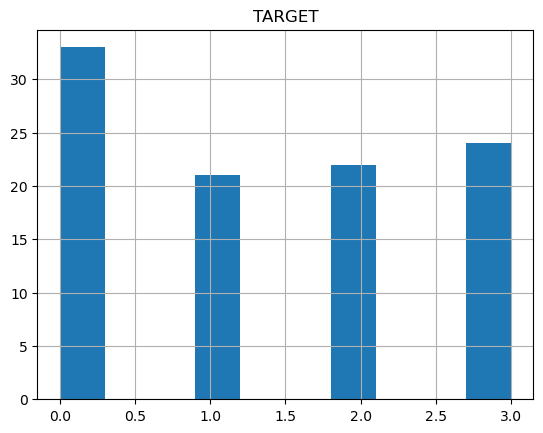

In [27]:
labels_df.hist('TARGET')

In [31]:
# Gather data for training 

# Loop through the train_slp_points and extract features using the process_slp_points function
features = []
targets = []
for idx, sample in tqdm(enumerate(train_slp_points), total=len(train_slp_points), desc="Processing samples"):
    # get file ID to match in labels_df
    file_id = train_slp_points[idx].video.filename.split('/')[-1].split('.')[0]
    features_sample = process_slp_points(sample)
    features.extend(features_sample)
    # get targets from labels_df and multiply by the length of features_sample
    # get the TARGET value from labels_df for the row with ID matching file_id
    targets.extend([labels_df[labels_df['ID'] == file_id]['TARGET'].values] * len(features_sample))
# Convert features and targets to numpy arrays
features = np.array(features)
targets = np.array(targets)


Processing samples: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


### Building a simple classifier

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42, shuffle=True)

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base XGBoost classifier
xgb = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    n_jobs=-1
)

# Create F1 scorer - using 'weighted' average since this is multiclass
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform grid search with cross validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Find best parameters
grid_search.fit(X_train, y_train.ravel())

# Get best model
best_xgb = grid_search.best_estimator_

# Make predictions on validation set
y_pred = best_xgb.predict(X_val)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")
print("\nValidation Set Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Best F1 score: 0.2404

Validation Set Results:
Accuracy: 0.2521
              precision    recall  f1-score   support

           0       0.29      0.59      0.39       118
           1       0.00      0.00      0.00        86
           2       0.06      0.01      0.02        67
           3       0.20      0.22      0.21        94

    accuracy                           0.25       365
   macro avg       0.14      0.21      0.16       365
weighted avg       0.16      0.25      0.19       365



The validation results are nothing to write home about. However, our baseline took a rudimentary approach. 
There are many timeseries related features that could be extracted from the data. 
Since the challenge also has a presentation component, feel free to systematically explore and report them even if they don't improve F1 scores.

## Inference on the test set

In [33]:
test_slp_points = load_slp_files('./data/keypoints_test')

In [34]:
# Loop through the test_slp_points and extract features using the process_slp_points function
# Since we are trying to predict the target, we will do a majority vote of the predictions of the subsequences
# from each video if there are multiple subsequences.
id = []
targets = []
for idx, sample in tqdm(enumerate(test_slp_points), total=len(test_slp_points), desc="Processing samples"):
    file_id = sample.video.filename.split('/')[-1].split('.')[0]
    id.append(file_id)

    try:
        features_sample = process_slp_points(sample)
    except:
        features_sample = process_slp_points(sample, use_all_frames=True)
    try:
        predictions = best_xgb.predict(features_sample)
    except:
        # Error handling for when the model fails to predict, investigate and improve these cases
        predictions = [0]
    # get the most frequent prediction
    most_frequent_prediction = np.bincount(predictions).argmax()
    targets.append(most_frequent_prediction)

df = pd.DataFrame({'ID': id, 'TARGET': targets})
df.to_csv('submission.csv', index=False)


Processing samples: 100%|██████████| 90/90 [00:18<00:00,  4.91it/s]


## Closing Remarks
- There is a slight class imbalance with the control class (class 0) being over-represented.
- The evaluation metric is macro-averaged F1 score, so tuning classifiers for this metric will result in better leaderboard scores.
- Negative results are encouraged in the competition. So, document your results and present them in the presentation. 
- If you have any questions, feel free to reach out in the discussion forum.
- If you made it this far, congratulations!

-End-